# Winter data for Axis 75 kHz ADCP
**Full depth tidal filters from January 1 - February 28, 2018**

## Imports

In [35]:
import qgrid
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import scipy.signal as sig
import scipy.interpolate as interp
import pandas as pd
%matplotlib notebook

In [8]:
# Axis January and February

with xr.open_dataset('../Nov11/AxisJanFeb2018.nc') as ds:
    print(ds)

<xarray.Dataset>
Dimensions:    (depth: 80, latitude: 1, longitude: 1, time: 1404)
Coordinates:
  * time       (time) datetime64[ns] 2018-01-01T00:30:00.000003328 ... 2018-02-28T11:29:59.999996672
  * depth      (depth) float32 968.2709 960.2709 ... 344.27084 336.27084
  * latitude   (latitude) float32 48.3166
  * longitude  (longitude) float32 -126.0508
Data variables:
    u          (time, depth) float32 ...
    v          (time, depth) float32 ...
    w          (time, depth) float32 ...
    temp       (time) float32 ...
Attributes:
    Conventions:                             CF-1.6
    title:                                   Ocean Networks Canada RDI ADCP Data
    institution:                             Ocean Networks Canada
    source:                                  Fixed-position Teledyne-RDI ADCP...
    history:                                 data extracted from raw output, ...
    references:                              http://www.oceannetworks.ca/
    CREATION_DATE:    

In [27]:
grid = pd.DataFrame(uorig)
qgrid.show_grid(grid, show_toolbar=True)

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

## Depth

**Find specific depth to remove depth values (unreliable data, from visual inspection of initial plots), about 100m at the top**

In [13]:
# find specific depth to remove depth values (unreliable data, from visual inspection of initial plots)
# about 100m at the top
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx     # returns index of nearest value

array = ds.depth
upval = 450        # meters
upidx = find_nearest(array, upval)

print("Index at cutoff:", find_nearest(array, upval))
print("Value at cutoff:", abs(array[find_nearest(array, upval)]))

depth = np.array(ds.depth[0:upidx+1])       # remove unwanted upper depths

print("Length of new array: ", len(depth))

Index at cutoff: 65
Value at cutoff: <xarray.DataArray 'depth' ()>
array(448.27084, dtype=float32)
Coordinates:
    depth    float32 448.27084
Length of new array:  66


## Filter

**Low pass Butterworth filter for 30 hours to remove tides**

In [17]:
# low pass Butterworth filter for 30 hours to remove tides

fs = 1                # 1 sample per hour for entire time series
fc = 0.033            # 30 hour low pass filter
Wn = fc / (fs / 2)    # normalised cut-off frequencies
b, a = sig.butter(12, Wn, 'lowpass')  # digital butterworth filter
w, h = sig.freqz(b, a, fs = 1)

**Loop to acquire original, filtered, and residual data**

In [18]:
# loop to filter tides from all depths

t = len(ds.time)               # number of time data points
d = len(depth)                 # number of depth data points after removing upper portion
days = t/24                    # number of days
time = np.linspace(0,days,t)   # x-range

In [60]:
uorig = np.empty([t,d])        # empty array for original u data
vorig = np.empty([t,d])        # empty array for original v data
worig = np.empty([t,d])        # empty array for original w data

ulp = np.empty([t,d])          # empty array for low-pass filtered u values
vlp = np.empty([t,d])          # empty array for low-pass filtered v values
wlp = np.empty([t,d])          # empty array for low-pass filtered w values

for j in range(d):
    utemp = pd.Series(ds.u[:,j])
    uint = utemp.interpolate(method="cubic")
    uorig[:,j] = uint                    # set interpolated data to original array
    ulp[:,j] = sig.filtfilt(b, a, uint)  # set low pass array values
    
    vtemp = pd.Series(ds.v[:,j])
    vint = vtemp.interpolate(method="cubic")
    vorig[:,j] = vint                    # set interpolated data to original array
    vlp[:,j] = sig.filtfilt(b, a, vint)  # set low pass array values
    
    wtemp = pd.Series(ds.w[:,j])
    wint = wtemp.interpolate(method="cubic")
    worig[:,j] = wint                    # set interpolated data to original array
    wlp[:,j] = sig.filtfilt(b, a, wint)  # set low pass array values
    
uhp = uorig - ulp
vhp = vorig - vlp
whp = worig - wlp

## Plots

**Plots for original, filtered, and residual data**

<IPython.core.display.Javascript object>


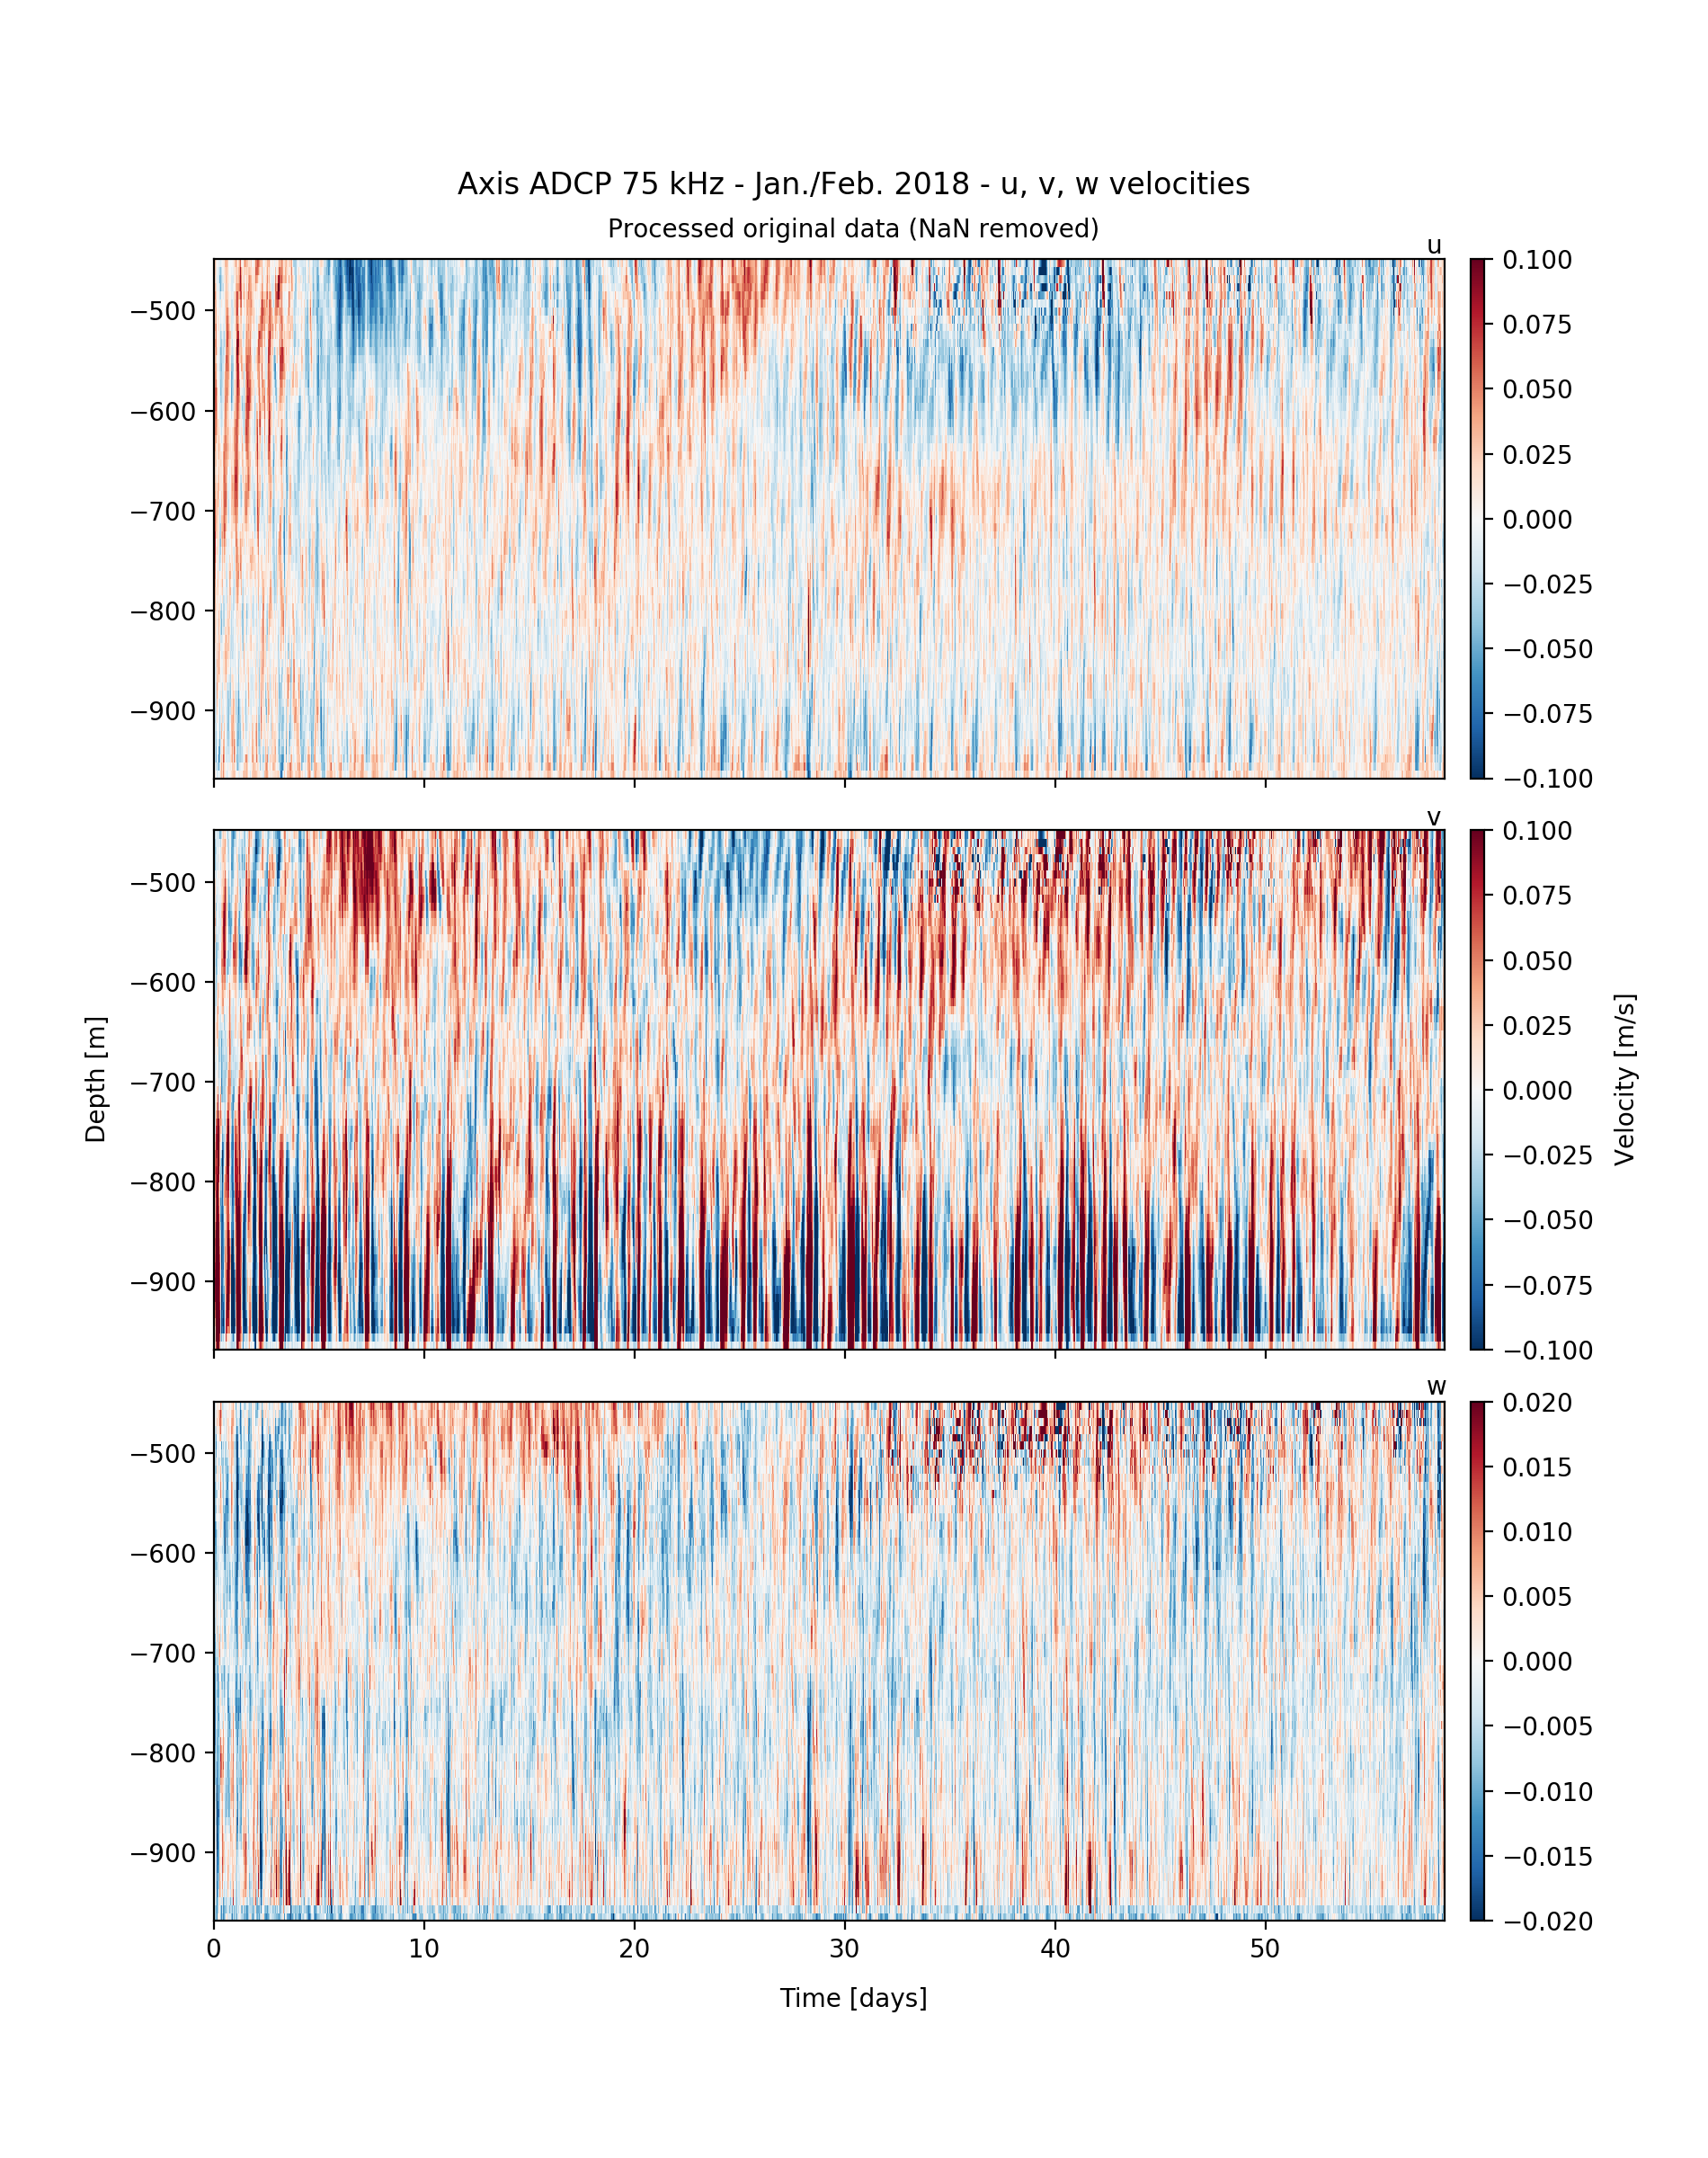

In [61]:
# plot original data

fig, (ax1,ax2,ax3) = plt.subplots(3, 1, figsize=(9.5,12), sharex = True)
fig.subplots_adjust(hspace = 0.1)
fig.text(0.5, 0.91, 'Axis ADCP 75 kHz - Jan./Feb. 2018 - u, v, w velocities', ha='center', fontsize=12)
fig.text(0.5, 0.89, 'Processed original data (NaN removed)', ha='center', fontsize=10)
fig.text(0.05, 0.5, 'Depth [m]', va='center', rotation='vertical')
fig.text(0.835, 0.886, 'u', va='center')
fig.text(0.835, 0.621, 'v', va='center')
fig.text(0.835, 0.357, 'w', va='center')
fig.text(0.945, 0.5, 'Velocity [m/s]', va='center', rotation='vertical')
fig.text(0.5, 0.07, 'Time [days]', ha='center')

im1 = ax1.pcolormesh(time, -depth, uorig.T, rasterized=True, cmap='RdBu_r', vmin=-0.1, vmax=0.1)
cbar1 = fig.colorbar(im1, ax=ax1, fraction=0.05, pad=0.02, aspect=40)

im2 = ax2.pcolormesh(time, -depth, vorig.T, rasterized=True, cmap='RdBu_r', vmin=-0.1, vmax=0.1)
cbar2 = fig.colorbar(im2, ax=ax2, fraction=0.05, pad=0.02, aspect=40)

im3 = ax3.pcolormesh(time, -depth, worig.T, rasterized=True, cmap='RdBu_r', vmin=-0.02, vmax=0.02)
cbar3 = fig.colorbar(im3, ax=ax3, fraction=0.05, pad=0.02, aspect=40)

It appears that there are some noticeable bi-monthly shifts in direction at shallower depths. There may be some bad data present in the upper-right.

<IPython.core.display.Javascript object>


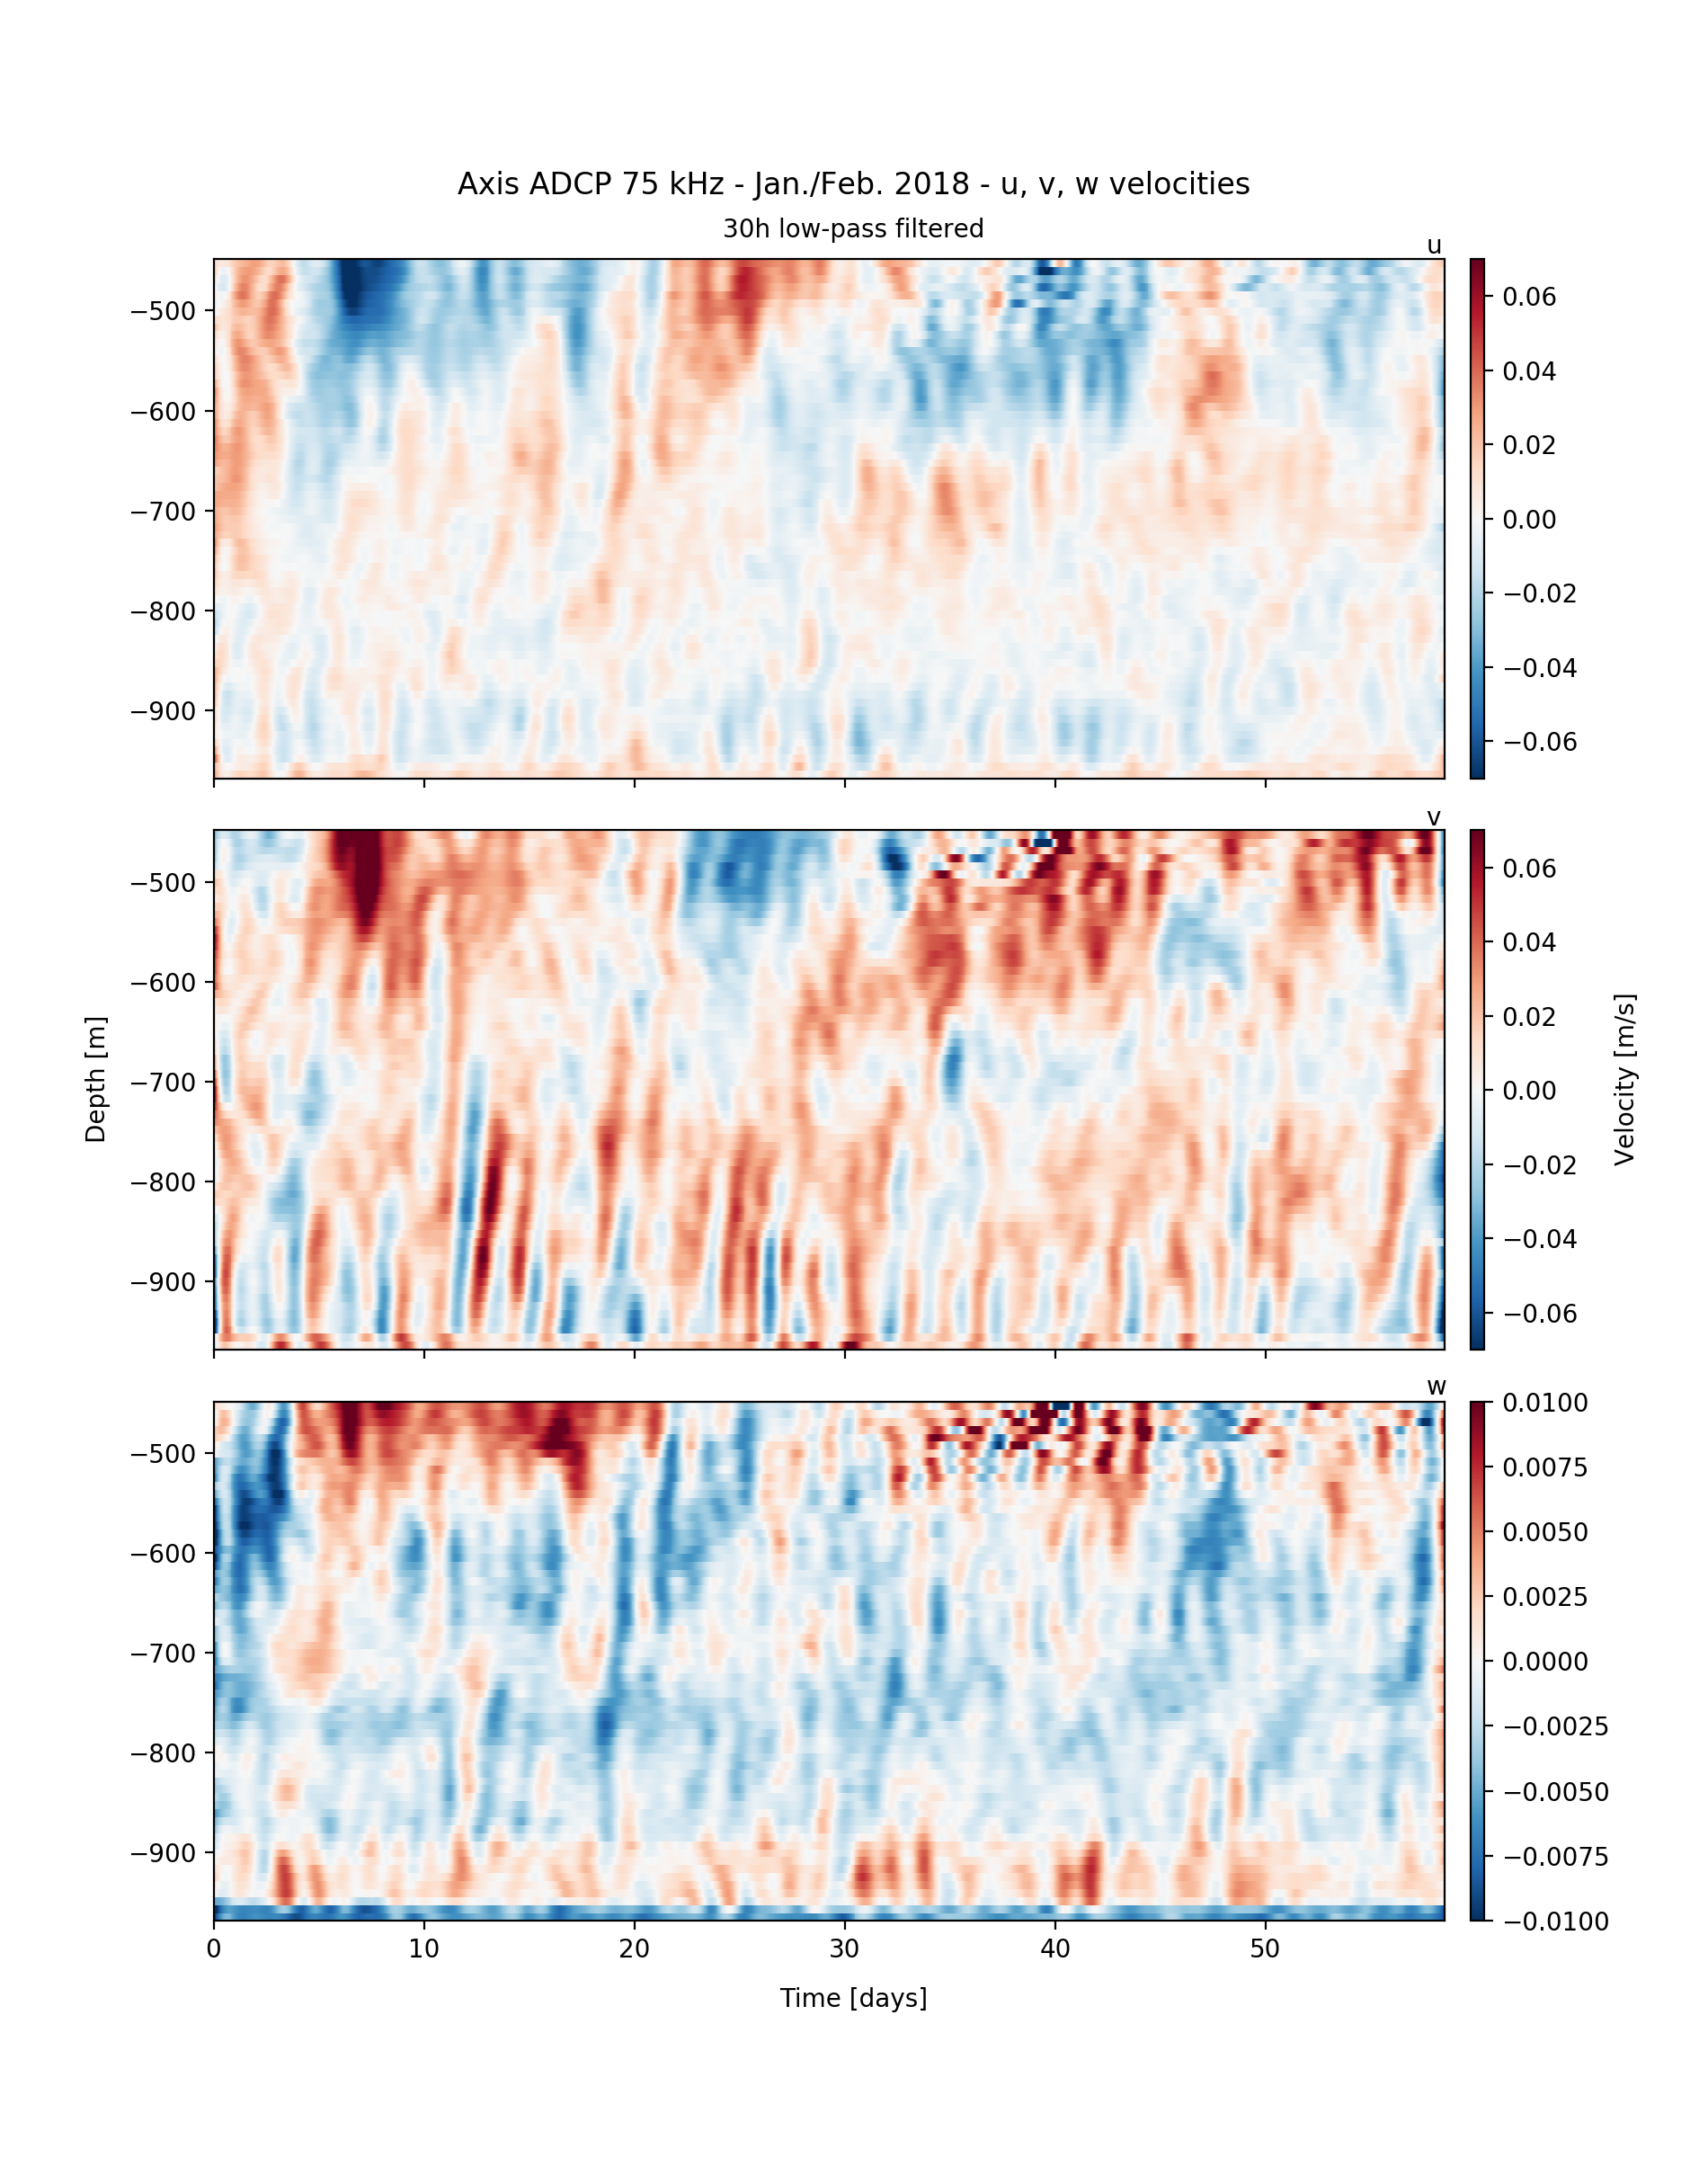

In [62]:
# plot low-pass data

fig, (ax1,ax2,ax3) = plt.subplots(3, 1, figsize=(9.5,12), sharex = True)
fig.subplots_adjust(hspace = 0.1)
fig.text(0.5, 0.91, 'Axis ADCP 75 kHz - Jan./Feb. 2018 - u, v, w velocities', ha='center', fontsize=12)
fig.text(0.5, 0.89, '30h low-pass filtered', ha='center', fontsize=10)
fig.text(0.05, 0.5, 'Depth [m]', va='center', rotation='vertical')
fig.text(0.835, 0.886, 'u', va='center')
fig.text(0.835, 0.621, 'v', va='center')
fig.text(0.835, 0.357, 'w', va='center')
fig.text(0.945, 0.5, 'Velocity [m/s]', va='center', rotation='vertical')
fig.text(0.5, 0.07, 'Time [days]', ha='center')

im1 = ax1.pcolormesh(time, -depth, ulp.T, rasterized=True, cmap='RdBu_r', vmin=-0.07, vmax=0.07)
cbar1 = fig.colorbar(im1, ax=ax1, fraction=0.05, pad=0.02, aspect=40)

im2 = ax2.pcolormesh(time, -depth, vlp.T, rasterized=True, cmap='RdBu_r', vmin=-0.07, vmax=0.07)
cbar2 = fig.colorbar(im2, ax=ax2, fraction=0.05, pad=0.02, aspect=40)

im3 = ax3.pcolormesh(time, -depth, wlp.T, rasterized=True, cmap='RdBu_r', vmin=-0.01, vmax=0.01)
cbar3 = fig.colorbar(im3, ax=ax3, fraction=0.05, pad=0.02, aspect=40)

Mean currents do seem to emphasise the shallower depth bi-monthly shifts noted above. Again, there may be some bad data present in the upper-right.

<IPython.core.display.Javascript object>


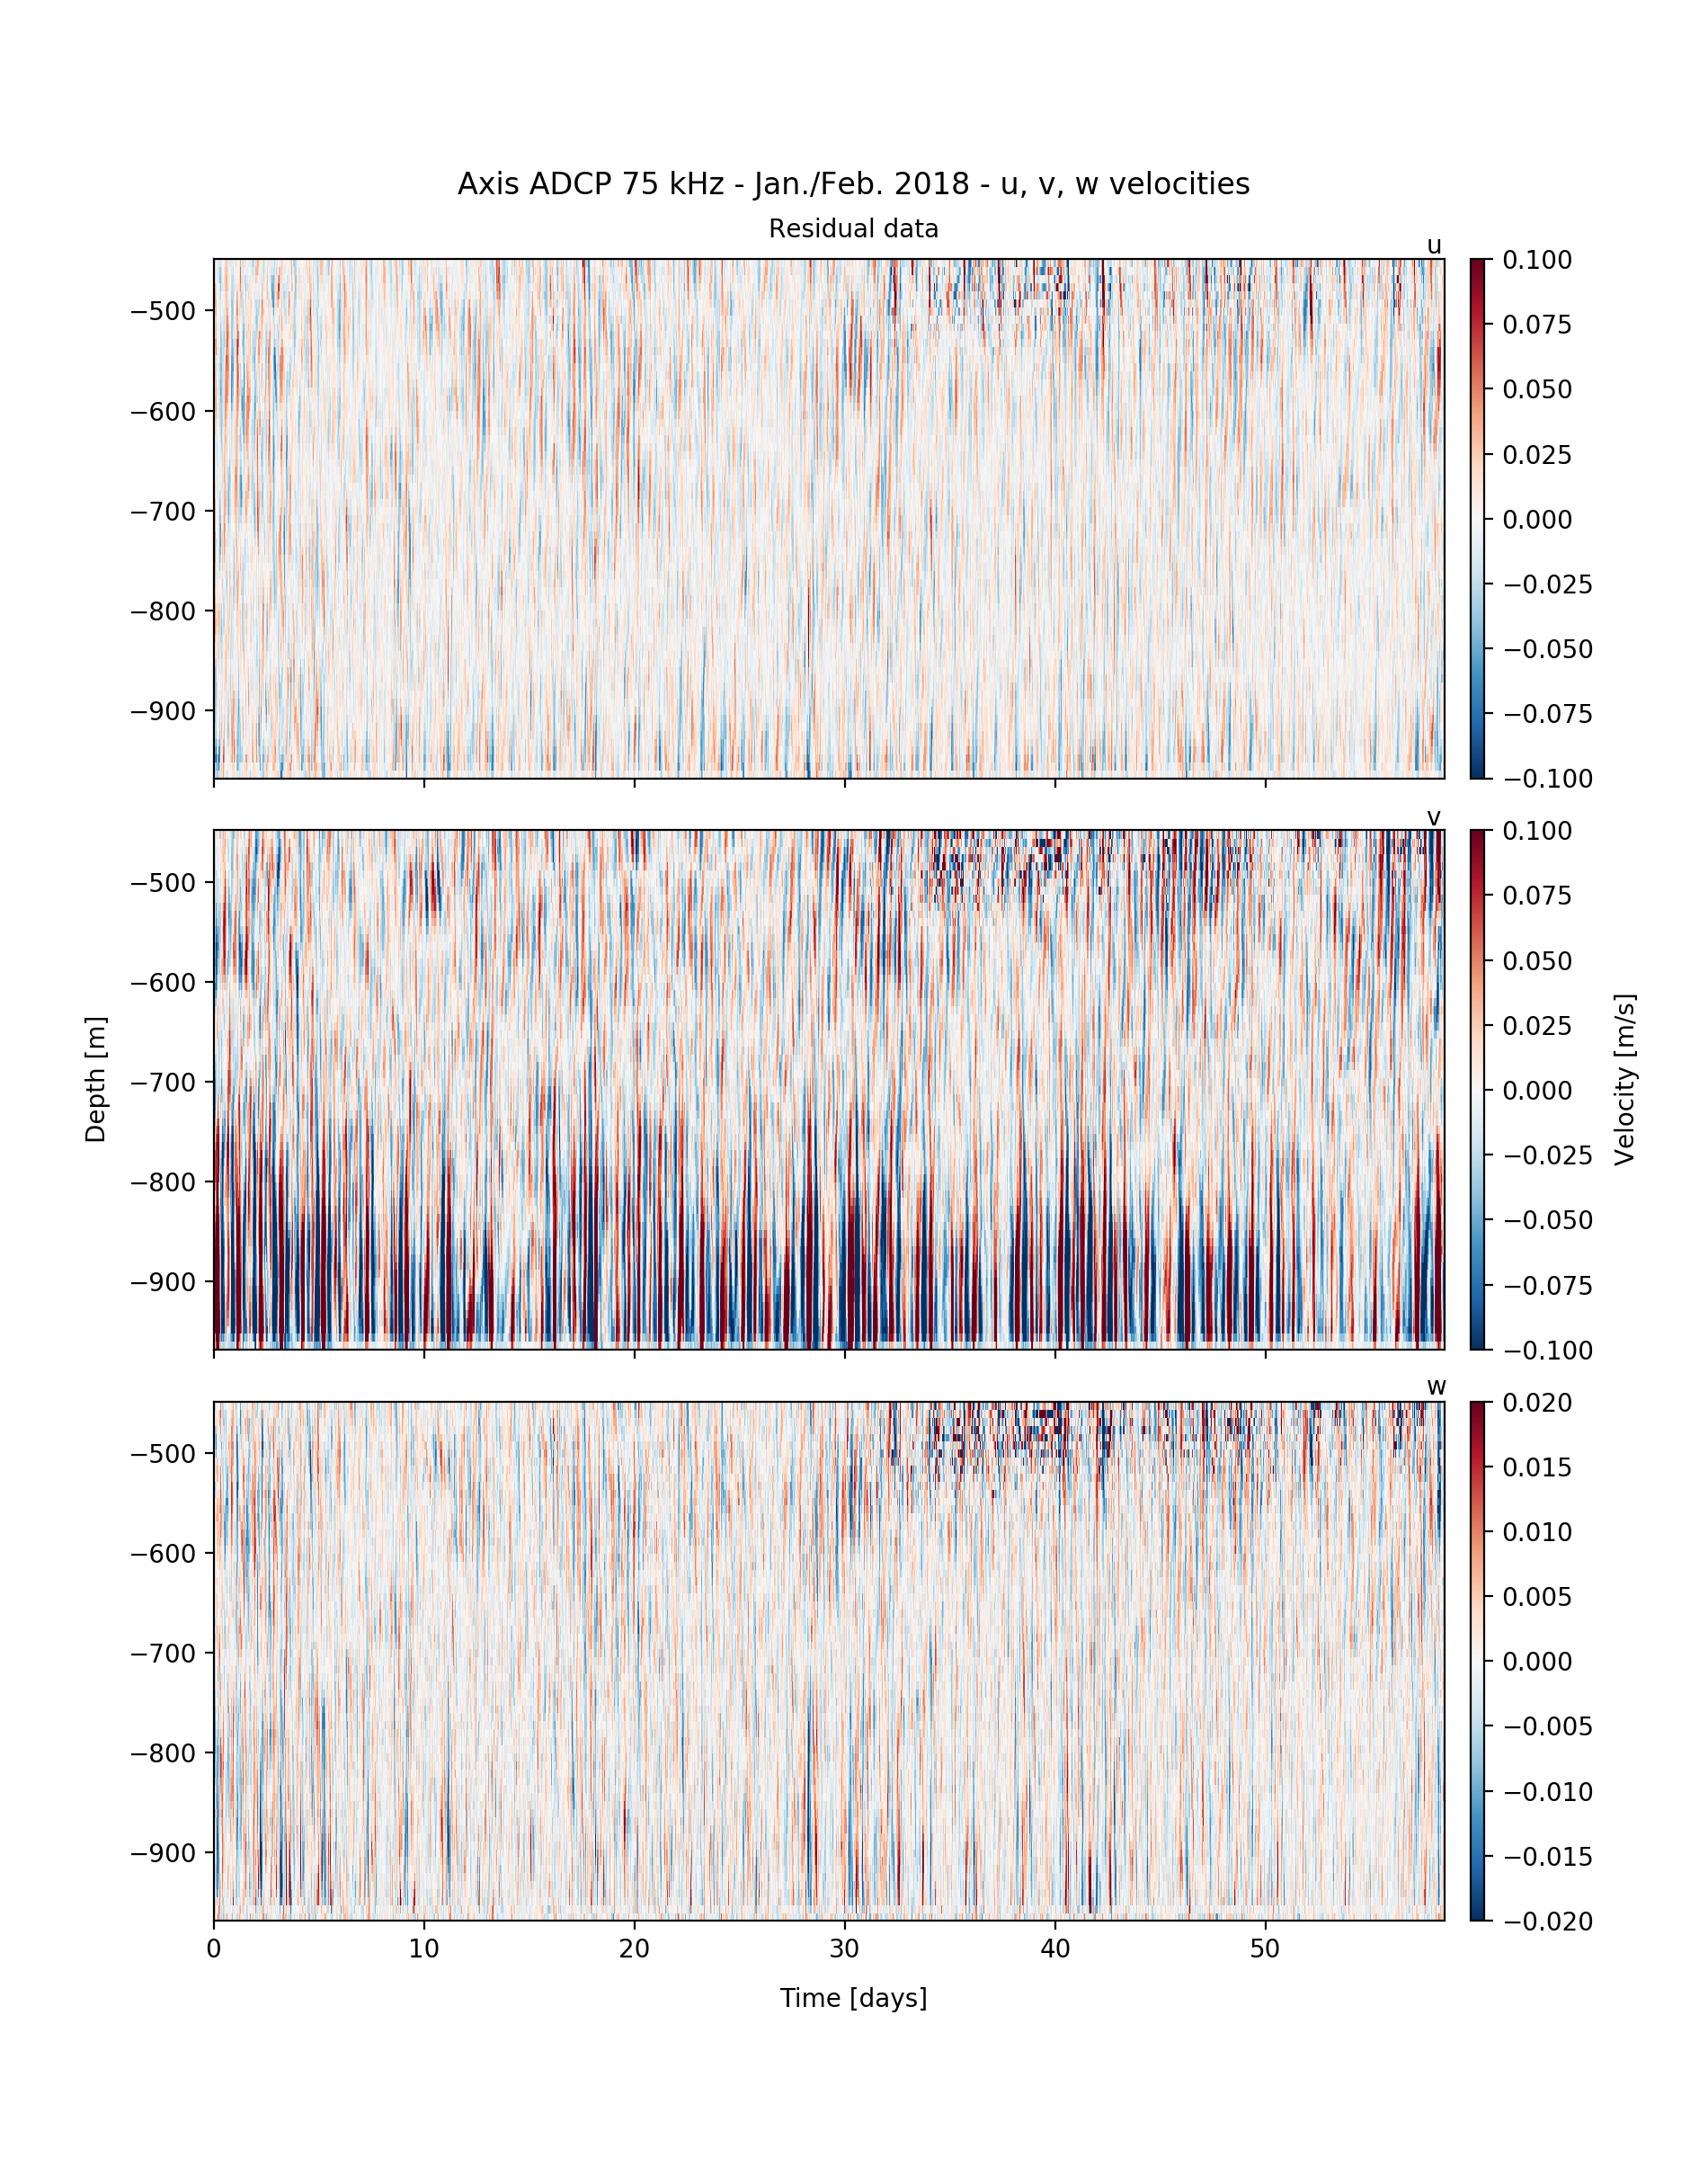

In [63]:
# plot residual data - zoom in, high frequency fluctuations appear to be tidal (K1, M2, M4, etc.)

fig, (ax1,ax2,ax3) = plt.subplots(3, 1, figsize=(9.5,12), sharex = True)
fig.subplots_adjust(hspace = 0.1)
fig.text(0.5, 0.91, 'Axis ADCP 75 kHz - Jan./Feb. 2018 - u, v, w velocities', ha='center', fontsize=12)
fig.text(0.5, 0.89, 'Residual data', ha='center', fontsize=10)
fig.text(0.05, 0.5, 'Depth [m]', va='center', rotation='vertical')
fig.text(0.835, 0.886, 'u', va='center')
fig.text(0.835, 0.621, 'v', va='center')
fig.text(0.835, 0.357, 'w', va='center')
fig.text(0.945, 0.5, 'Velocity [m/s]', va='center', rotation='vertical')
fig.text(0.5, 0.07, 'Time [days]', ha='center')

im1 = ax1.pcolormesh(time, -depth, uhp.T, rasterized=True, cmap='RdBu_r', vmin=-0.1, vmax=0.1)
cbar1 = fig.colorbar(im1, ax=ax1, fraction=0.05, pad=0.02, aspect=40)

im2 = ax2.pcolormesh(time, -depth, vhp.T, rasterized=True, cmap='RdBu_r', vmin=-0.1, vmax=0.1)
cbar2 = fig.colorbar(im2, ax=ax2, fraction=0.05, pad=0.02, aspect=40)

im3 = ax3.pcolormesh(time, -depth, whp.T, rasterized=True, cmap='RdBu_r', vmin=-0.02, vmax=0.02)
cbar3 = fig.colorbar(im3, ax=ax3, fraction=0.05, pad=0.02, aspect=40)

Residual data seems mostly uninteresting at this depth, though with stronger fluctuations in v near the bottom. Again, there may be some bad data present in the upper-right.

# Summer Data for Axis 75 kHz ADCP
**Coded as above**

Only good from June 1 - June 22.

## Imports

In [64]:
# Axis June and July

with xr.open_dataset('../Nov11/AxisJunJul2018.nc') as ds:
    print(ds)

<xarray.Dataset>
Dimensions:    (depth: 80, latitude: 1, longitude: 1, time: 515)
Coordinates:
  * time       (time) datetime64[ns] 2018-06-01T00:30:00.000003328 ... 2018-06-22T10:30:00
  * depth      (depth) float32 968.27325 960.27325 ... 344.27325 336.27325
  * latitude   (latitude) float32 48.3166
  * longitude  (longitude) float32 -126.0508
Data variables:
    u          (time, depth) float32 ...
    v          (time, depth) float32 ...
    w          (time, depth) float32 ...
    temp       (time) float32 ...
Attributes:
    Conventions:                             CF-1.6
    title:                                   Ocean Networks Canada RDI ADCP Data
    institution:                             Ocean Networks Canada
    source:                                  Fixed-position Teledyne-RDI ADCP...
    history:                                 data extracted from raw output, ...
    references:                              http://www.oceannetworks.ca/
    CREATION_DATE:             

## Depth

In [65]:
# find specific depth to remove depth values (unreliable data, from visual inspection of initial plots)
# about 100m at the top
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx     # returns index of nearest value

array = ds.depth
upval = 450        # meters
upidx = find_nearest(array, upval)

print("Index at cutoff:", find_nearest(array, upval))
print("Value at cutoff:", abs(array[find_nearest(array, upval)]))

depth = np.array(ds.depth[0:upidx+1])       # remove unwanted upper depths

print("Length of new array: ", len(depth))

Index at cutoff: 65
Value at cutoff: <xarray.DataArray 'depth' ()>
array(448.27325, dtype=float32)
Coordinates:
    depth    float32 448.27325
Length of new array:  66


## Filter

In [66]:
# low pass Butterworth filter for 30 hours to remove tides

fs = 1                # 1 sample per hour for entire time series
fc = 0.033            # 30 hour low pass filter
Wn = fc / (fs / 2)    # normalised cut-off frequencies
b, a = sig.butter(12, Wn, 'lowpass')  # digital butterworth filter
w, h = sig.freqz(b, a, fs = 1)

In [67]:
# loop to filter tides from all depths

t = len(ds.time)               # number of time data points
d = len(depth)                 # number of depth data points after removing upper portion
days = t/24                    # number of days
time = np.linspace(0,days,t)   # x-range

uorig = np.empty([t,d])        # empty array for original u data
vorig = np.empty([t,d])        # empty array for original v data
worig = np.empty([t,d])        # empty array for original w data

ulp = np.empty([t,d])          # empty array for low-pass filtered u values
vlp = np.empty([t,d])          # empty array for low-pass filtered v values
wlp = np.empty([t,d])          # empty array for low-pass filtered w values

for j in range(d):
    utemp = pd.Series(ds.u[:,j])
    uint = utemp.interpolate(method="cubic")
    uorig[:,j] = uint                    # set interpolated data to original array
    ulp[:,j] = sig.filtfilt(b, a, uint)  # set low pass array values
    
    vtemp = pd.Series(ds.v[:,j])
    vint = vtemp.interpolate(method="cubic")
    vorig[:,j] = vint                    # set interpolated data to original array
    vlp[:,j] = sig.filtfilt(b, a, vint)  # set low pass array values
    
    wtemp = pd.Series(ds.w[:,j])
    wint = wtemp.interpolate(method="cubic")
    worig[:,j] = wint                    # set interpolated data to original array
    wlp[:,j] = sig.filtfilt(b, a, wint)  # set low pass array values
    
uhp = uorig - ulp
vhp = vorig - vlp
whp = worig - wlp

## Plots

<IPython.core.display.Javascript object>


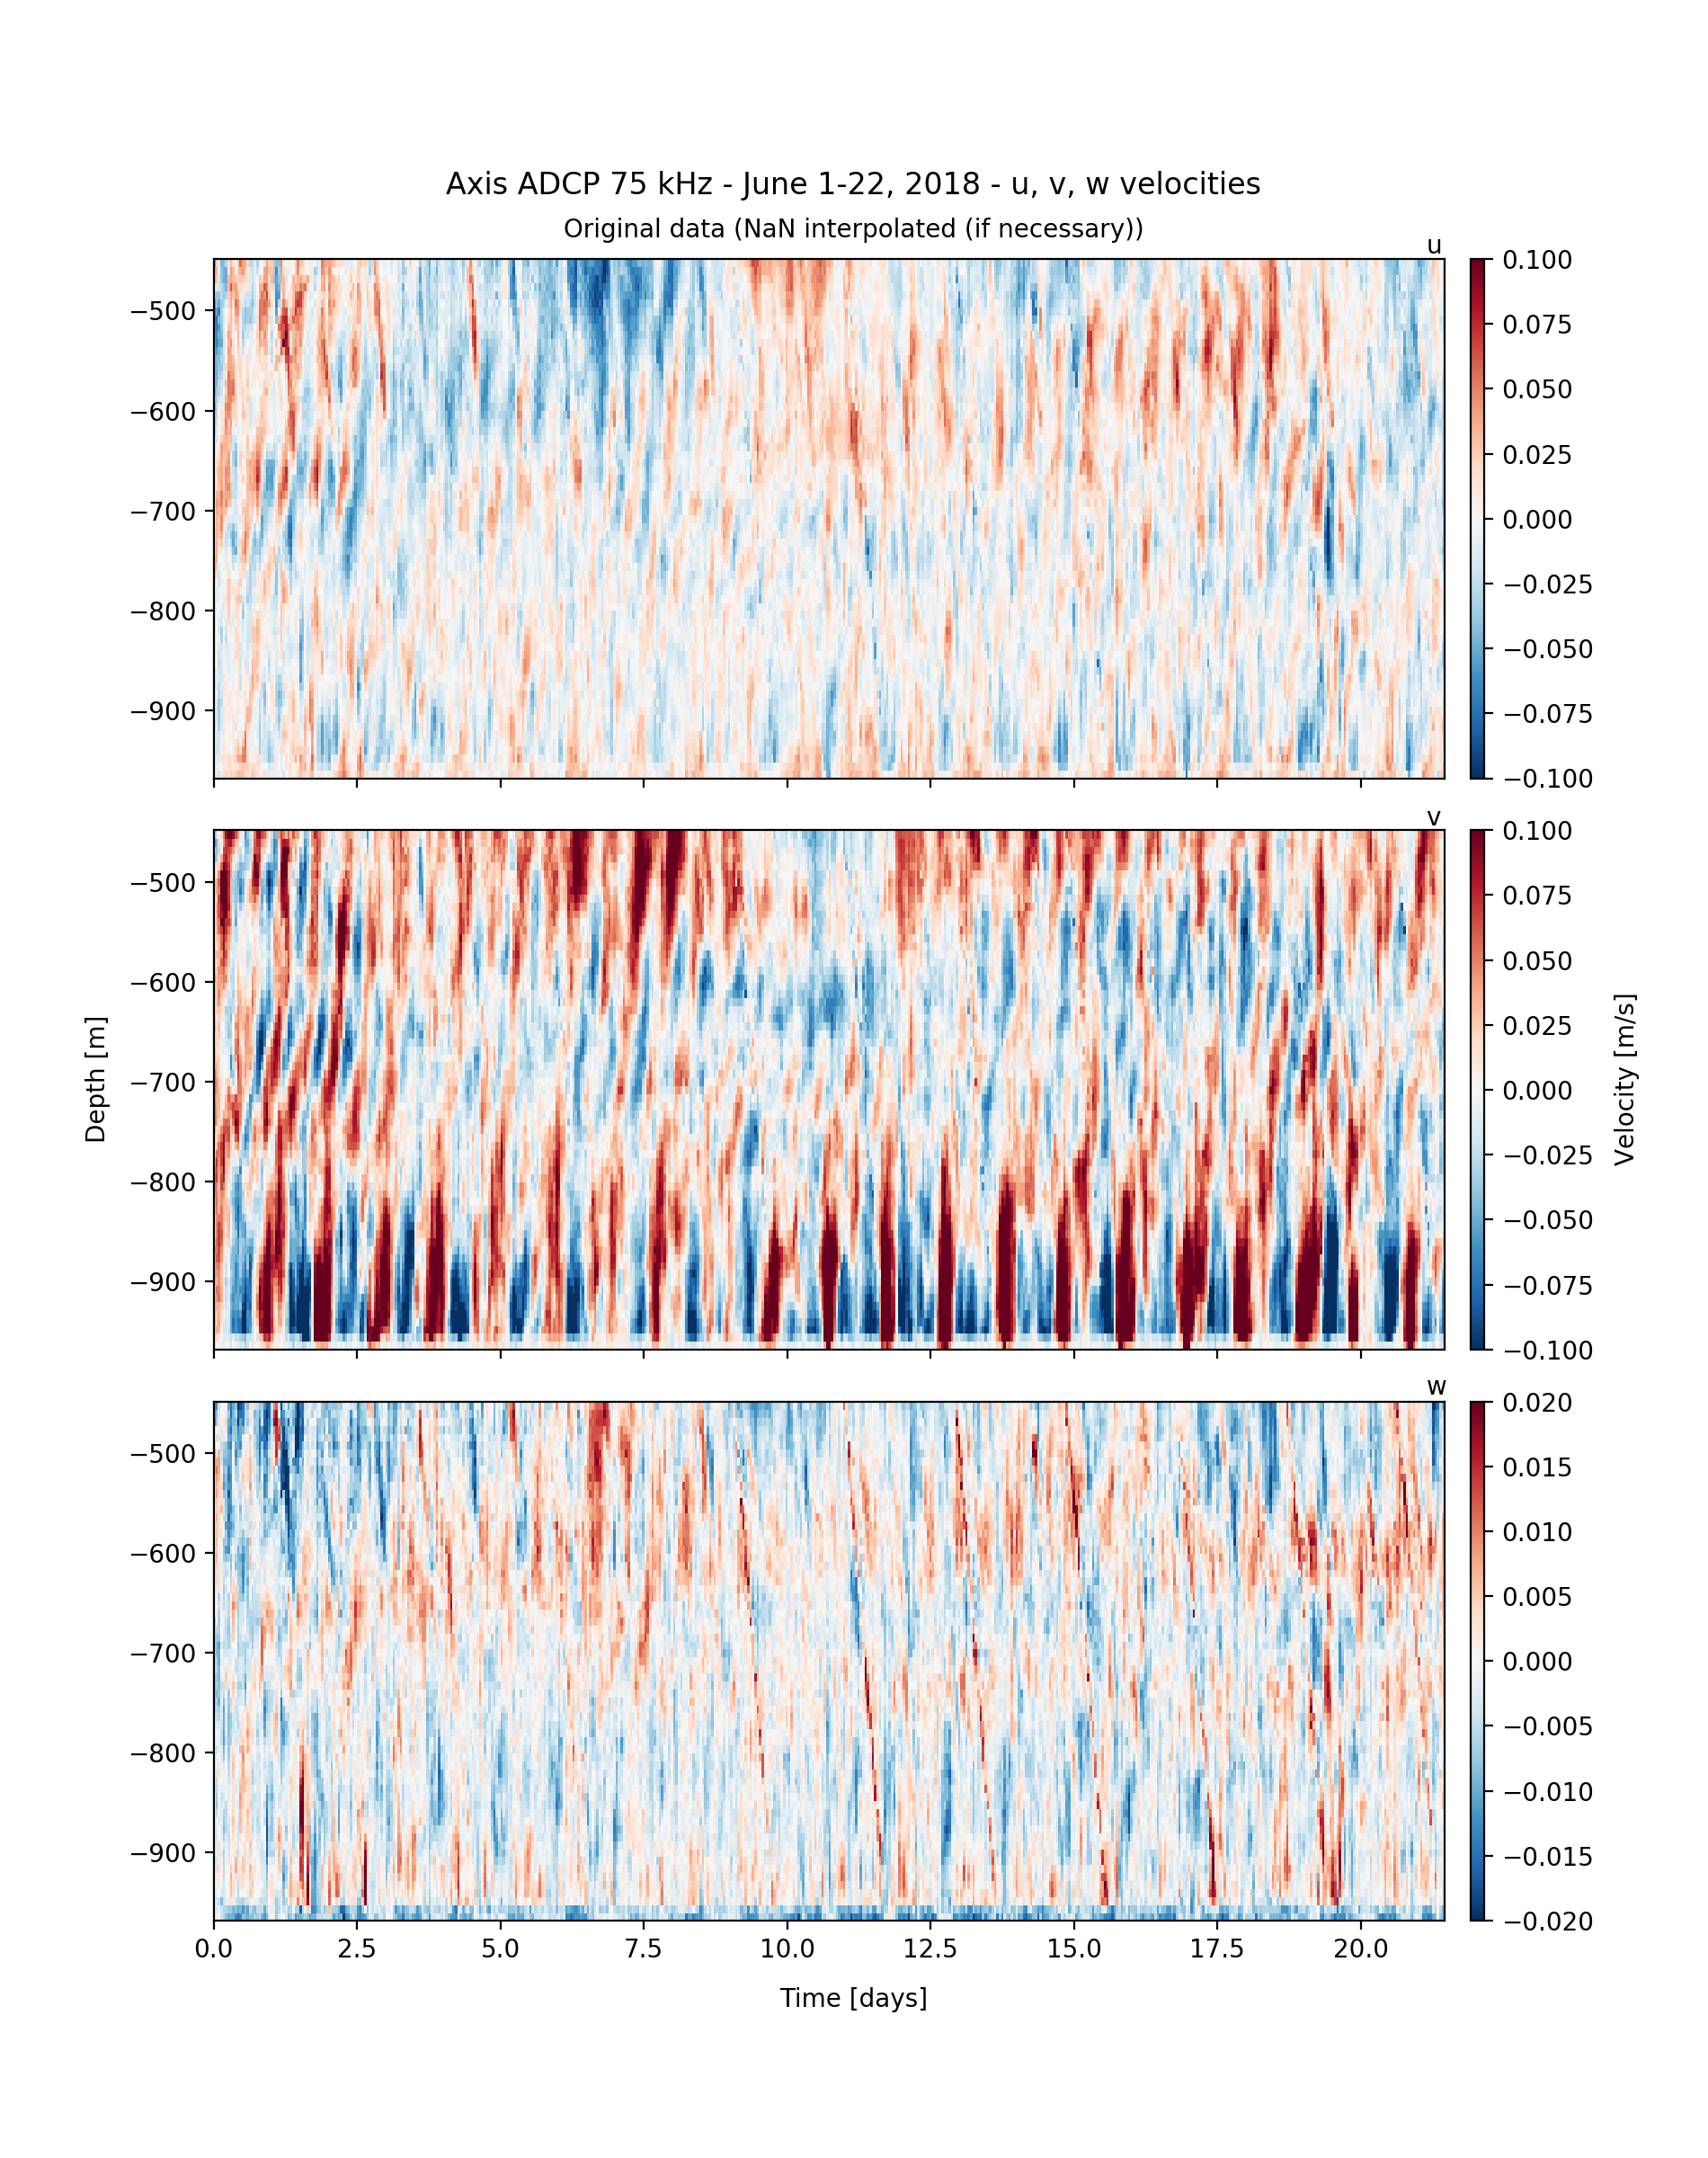

In [68]:
# plot original data

fig, (ax1,ax2,ax3) = plt.subplots(3, 1, figsize=(9.5,12), sharex = True)
fig.subplots_adjust(hspace = 0.1)
fig.text(0.5, 0.91, 'Axis ADCP 75 kHz - June 1-22, 2018 - u, v, w velocities', ha='center', fontsize=12)
fig.text(0.5, 0.89, 'Original data (NaN interpolated (if necessary))', ha='center', fontsize=10)
fig.text(0.05, 0.5, 'Depth [m]', va='center', rotation='vertical')
fig.text(0.835, 0.886, 'u', va='center')
fig.text(0.835, 0.621, 'v', va='center')
fig.text(0.835, 0.357, 'w', va='center')
fig.text(0.945, 0.5, 'Velocity [m/s]', va='center', rotation='vertical')
fig.text(0.5, 0.07, 'Time [days]', ha='center')

im1 = ax1.pcolormesh(time, -depth, uorig.T, rasterized=True, cmap='RdBu_r', vmin=-0.1, vmax=0.1)
cbar1 = fig.colorbar(im1, ax=ax1, fraction=0.05, pad=0.02, aspect=40)

im2 = ax2.pcolormesh(time, -depth, vorig.T, rasterized=True, cmap='RdBu_r', vmin=-0.1, vmax=0.1)
cbar2 = fig.colorbar(im2, ax=ax2, fraction=0.05, pad=0.02, aspect=40)

im3 = ax3.pcolormesh(time, -depth, worig.T, rasterized=True, cmap='RdBu_r', vmin=-0.02, vmax=0.02)
cbar3 = fig.colorbar(im3, ax=ax3, fraction=0.05, pad=0.02, aspect=40)

It is difficult to distinguish any patterns in the original data. There is potentially a bi-weekly fluctuation at shallower depths.

<IPython.core.display.Javascript object>


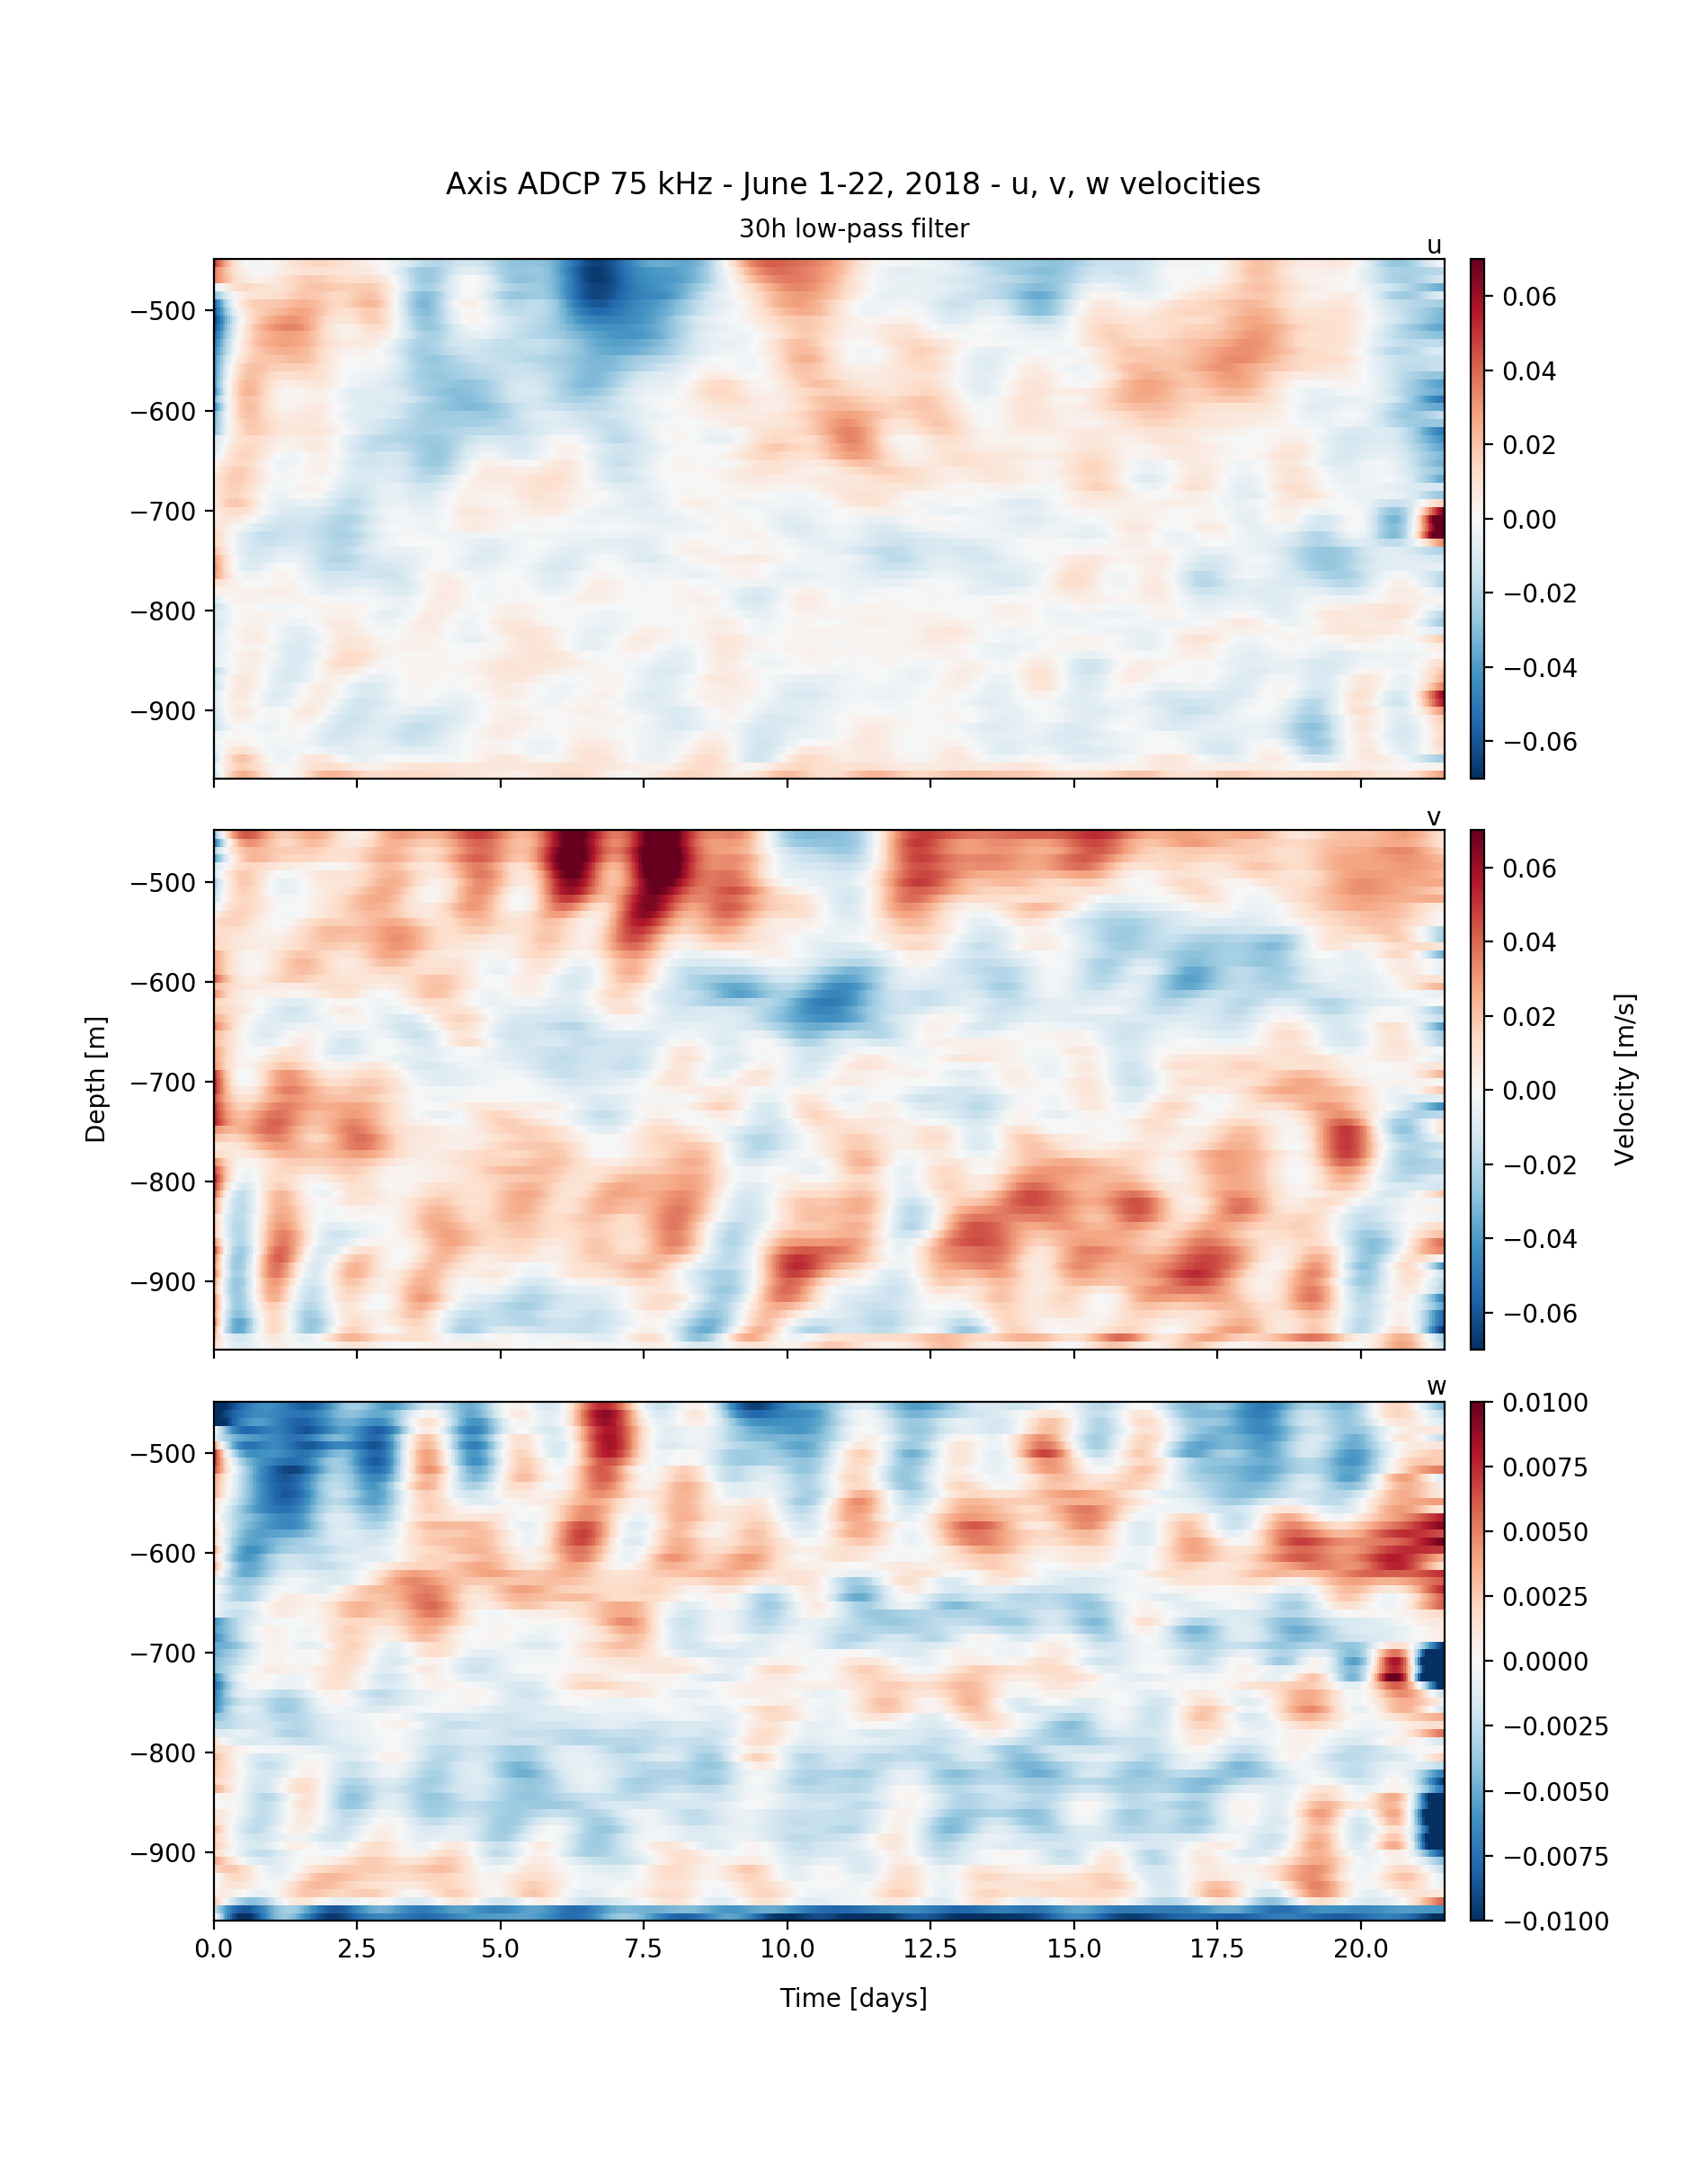

In [69]:
# plot low-pass data

fig, (ax1,ax2,ax3) = plt.subplots(3, 1, figsize=(9.5,12), sharex = True)
fig.subplots_adjust(hspace = 0.1)
fig.text(0.5, 0.91, 'Axis ADCP 75 kHz - June 1-22, 2018 - u, v, w velocities', ha='center', fontsize=12)
fig.text(0.5, 0.89, '30h low-pass filter', ha='center', fontsize=10)
fig.text(0.05, 0.5, 'Depth [m]', va='center', rotation='vertical')
fig.text(0.835, 0.886, 'u', va='center')
fig.text(0.835, 0.621, 'v', va='center')
fig.text(0.835, 0.357, 'w', va='center')
fig.text(0.945, 0.5, 'Velocity [m/s]', va='center', rotation='vertical')
fig.text(0.5, 0.07, 'Time [days]', ha='center')

im1 = ax1.pcolormesh(time, -depth, ulp.T, rasterized=True, cmap='RdBu_r', vmin=-0.07, vmax=0.07)
cbar1 = fig.colorbar(im1, ax=ax1, fraction=0.05, pad=0.02, aspect=40)

im2 = ax2.pcolormesh(time, -depth, vlp.T, rasterized=True, cmap='RdBu_r', vmin=-0.07, vmax=0.07)
cbar2 = fig.colorbar(im2, ax=ax2, fraction=0.05, pad=0.02, aspect=40)

im3 = ax3.pcolormesh(time, -depth, wlp.T, rasterized=True, cmap='RdBu_r', vmin=-0.01, vmax=0.01)
cbar3 = fig.colorbar(im3, ax=ax3, fraction=0.05, pad=0.02, aspect=40)

The mean currents are remarkably disorganised. There is still the potential for the bi-weekly fluctuation mentioned, above, but it is not definitive.

<IPython.core.display.Javascript object>


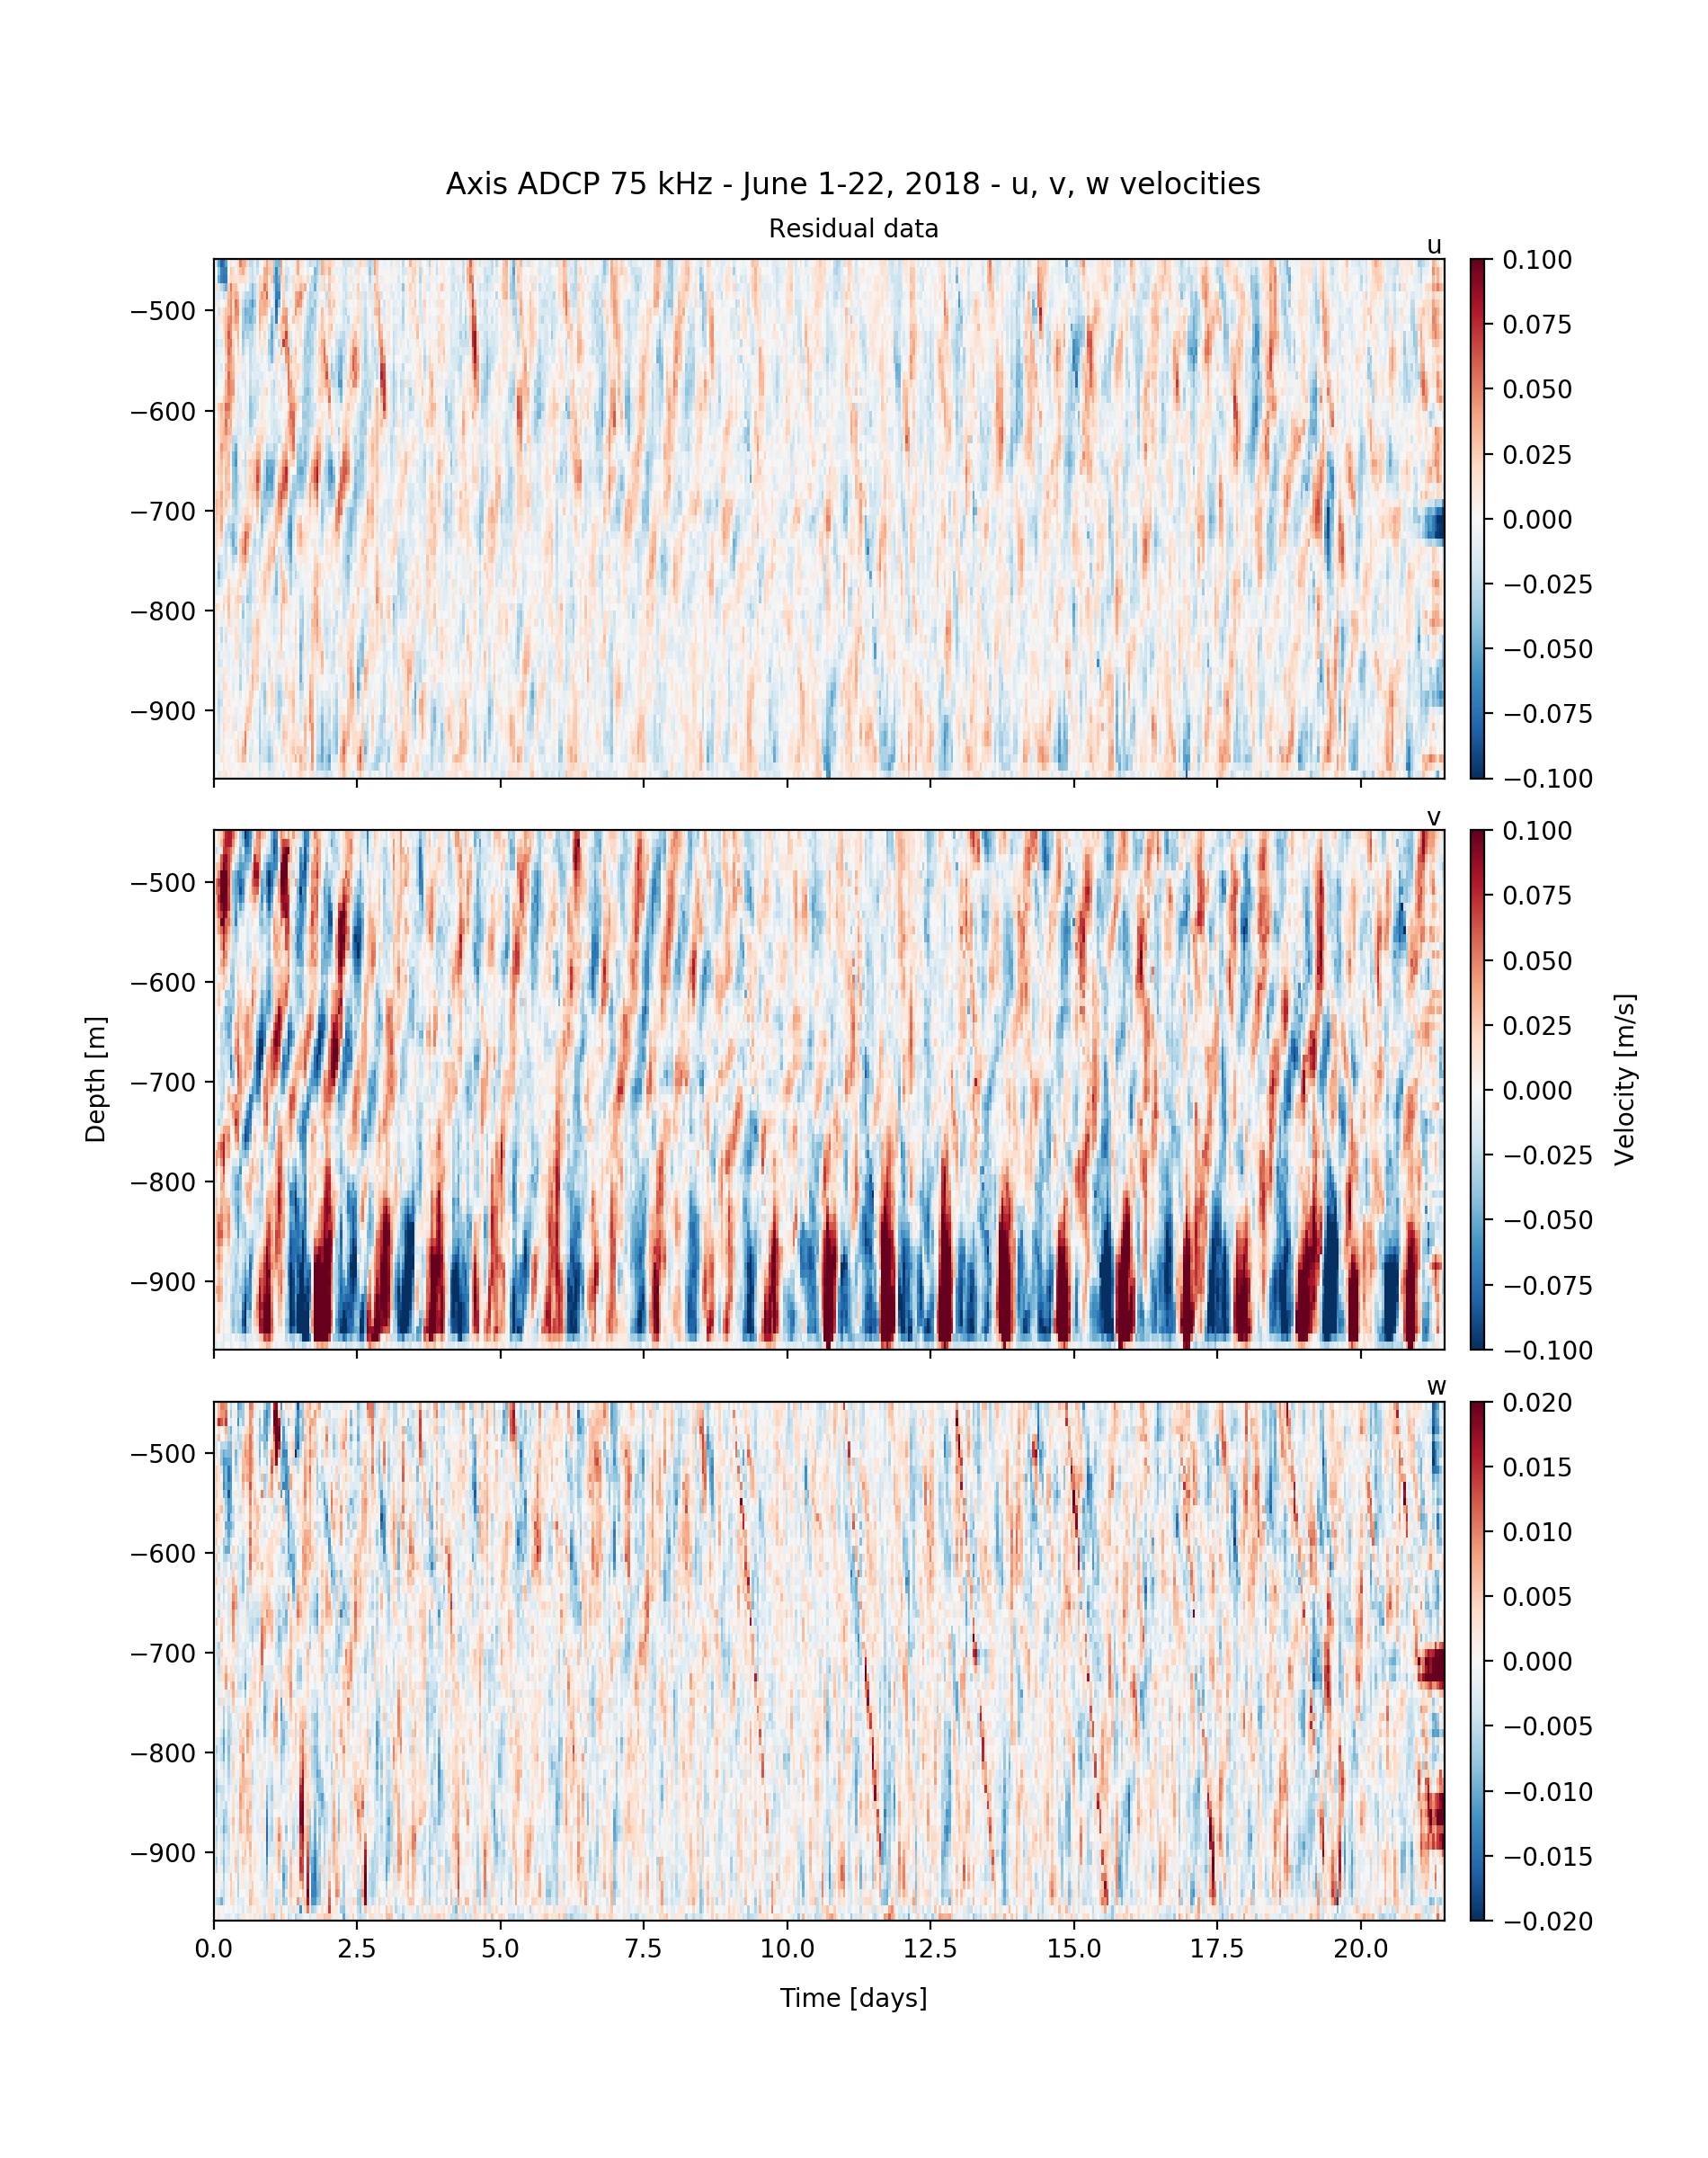

In [70]:
# plot residual data - zoom in, high frequency fluctuations appear to be tidal (K1, M2, M4, etc.)

fig, (ax1,ax2,ax3) = plt.subplots(3, 1, figsize=(9.5,12), sharex = True)
fig.subplots_adjust(hspace = 0.1)
fig.text(0.5, 0.91, 'Axis ADCP 75 kHz - June 1-22, 2018 - u, v, w velocities', ha='center', fontsize=12)
fig.text(0.5, 0.89, 'Residual data', ha='center', fontsize=10)
fig.text(0.05, 0.5, 'Depth [m]', va='center', rotation='vertical')
fig.text(0.835, 0.886, 'u', va='center')
fig.text(0.835, 0.621, 'v', va='center')
fig.text(0.835, 0.357, 'w', va='center')
fig.text(0.945, 0.5, 'Velocity [m/s]', va='center', rotation='vertical')
fig.text(0.5, 0.07, 'Time [days]', ha='center')

im1 = ax1.pcolormesh(time, -depth, uhp.T, rasterized=True, cmap='RdBu_r', vmin=-0.1, vmax=0.1)
cbar1 = fig.colorbar(im1, ax=ax1, fraction=0.05, pad=0.02, aspect=40)

im2 = ax2.pcolormesh(time, -depth, vhp.T, rasterized=True, cmap='RdBu_r', vmin=-0.1, vmax=0.1)
cbar2 = fig.colorbar(im2, ax=ax2, fraction=0.05, pad=0.02, aspect=40)

im3 = ax3.pcolormesh(time, -depth, whp.T, rasterized=True, cmap='RdBu_r', vmin=-0.02, vmax=0.02)
cbar3 = fig.colorbar(im3, ax=ax3, fraction=0.05, pad=0.02, aspect=40)

The relatively shorter time axis allows for better visualisation of the tides contained in the residual data, which seem to be strongest in the v velocities for what could potentially be the M2 frequency.